In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sys
import os
from PIL import Image
from cache import cache

Importing modules from keras

In [2]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import GRU, Embedding, Dense, Input
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [3]:
print(tf.__version__, tf.keras.__version__)

1.9.0 2.1.6-tf


#### Loading the Data 

In [4]:
import coco

In [5]:
coco.set_data_dir("./data/coco")

In [6]:
# coco.maybe_download_and_extract()

In [7]:
_, filenames_train, captions_train = coco.load_records(train=True)

- Data loaded from cache-file: /mnt/MyDrive/Datasets/image-cap/data/coco/records_train.pkl


In [8]:
num_train_img = len(filenames_train)
print(num_train_img)

118287


In [9]:
_, filenames_val, captions_val = coco.load_records(train=False)

- Data loaded from cache-file: /mnt/MyDrive/Datasets/image-cap/data/coco/records_val.pkl


In [10]:
num_val_img = len(filenames_val)
print(num_val_img)

5000


### Functions for loading & showing images 

In [11]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """
    
    img = Image.open(path) #loading image using PIL
    
    if not size is None:
        img = img.resize(size=size, resample= Image.LANCZOS)
    
    img = np.array(img) #img to numpy array
    
    img = img/255.0 #scaling them so they fall between 0 and 1
    
    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if len(img.shape) == 2:
        img = np.repeat(img[:,:,np.newaxis], 3, axis=2)
        
    return img

This is a helper-function for showing an image from the data-set along with its captions.



In [12]:
def show_image(idx, train):
    """
    Load and plot an image from the training- or validation-set
    with the given index.
    """
    
    if train: # uses image from training set
        dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
        
    else: # uses image from validation set
        dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]
        
    # path for the image file
    path = os.path.join(dir, filename)
    
    # printing the captions for this image
    for caption in captions:
        print(caption)
        
    # load the image & plot it
    image = load_image(path)
    plt.imshow(image)
    plt.show()        

### Testing loading & displaying image 

A giraffe eating food from the top of the tree.
A giraffe standing up nearby a tree 
A giraffe mother with its baby in the forest.
Two giraffes standing in a tree filled area.
A giraffe standing next to a forest filled with trees.


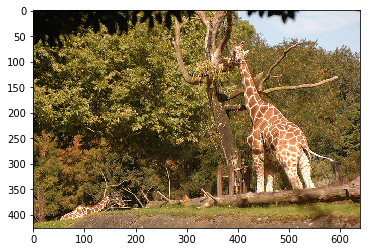

In [13]:
show_image(idx=1, train=True)

A woman posing for the camera standing on skis.
a woman standing on skiis while posing for the camera
A woman in a red jacket skiing down a slope
A young woman is skiing down the mountain slope. 
a person on skis makes her way through the snow


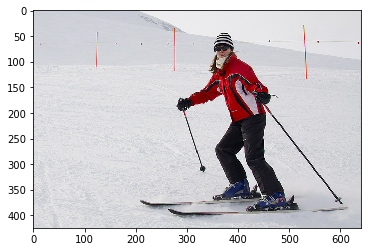

In [14]:
show_image(idx=5, train=False)

### Pretrained Image Model VGG16 

In [15]:
image_model = VGG16(include_top=True, weights='imagenet')

In [16]:
image_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

We will use the output of the layer prior to the final classification-layer which is named fc2. This is a fully-connected (or dense) layer.

In [17]:
transfer_layer = image_model.get_layer('fc2')

We call it the "transfer-layer" because we will transfer its output to another model that creates the image captions.

To do this, first we need to create a new model which has the same input as the original VGG16 model but outputs the transfer-values from the fc2 layer.

In [18]:
image_model_transfer = Model(inputs=image_model.input, outputs=transfer_layer.output)

The model will need input of the size:

In [19]:
img_size = K.int_shape(image_model.input)[1:3]
img_size

(224, 224)

For each input image, the new model will output a vector of transfer-values with this length:

In [20]:
transfer_values_size = K.int_shape(transfer_layer.output)[1]
transfer_values_size

4096

### Process all images 

We now make functions for processing all images in the data-set using the pre-trained image-model and saving the transfer-values in a cache-file so they can be reloaded quickly.

We effectively create a new data-set of the transfer-values. This is because it takes a long time to process an image in the VGG16 model. We will not be changing all the parameters of the VGG16 model, so every time it processes an image, it gives the exact same result. We need the transfer-values to train the image-captioning model for many epochs, so we save a lot of time by calculating the transfer-values once and saving them in a cache-file.

This is a helper-function for printing the progress.

In [21]:
def print_progress(count, max_count):
    # Percentage Completion
    pct_complete = count/max_count
    
    # Status-message. Note the \r which means the line should overwrite itself
    msg = '\r- Progress: {0:.1%}'.format(pct_complete)
    
    sys.stdout.write(msg)
    sys.stdout.flush()

This is the function for processing the given files using the VGG16-model and returning their transfer-values.

In [22]:
def process_images(data_dir, filenames, batch_size=32):
    """
    Process all the given files in the given data_dir using the
    pre-trained image-model and return their transfer-values.
    
    Note that we process the images in batches to save
    memory and improve efficiency on the GPU.
    """
    
    # Number of images to process.
    num_images = len(filenames)

    # Pre-allocate input-batch-array for images.
    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)

    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (num_images, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    # Initialize index into the filenames.
    start_index = 0

    # Process batches of image-files.
    while start_index < num_images:
        # Print the percentage-progress.
        print_progress(count=start_index, max_count=num_images)

        # End-index for this batch.
        end_index = start_index + batch_size

        # Ensure end-index is within bounds.
        if end_index > num_images:
            end_index = num_images

        # The last batch may have a different batch-size.
        current_batch_size = end_index - start_index

        # Load all the images in the batch.
        for i, filename in enumerate(filenames[start_index:end_index]):
            # Path for the image-file.
            path = os.path.join(data_dir, filename)

            # Load and resize the image.
            # This returns the image as a numpy-array.
            img = load_image(path, size=img_size)

            # Save the image for later use.
            image_batch[i] = img

        # Use the pre-trained image-model to process the image.
        # Note that the last batch may have a different size,
        # so we only use the relevant images.
        transfer_values_batch = \
            image_model_transfer.predict(image_batch[0:current_batch_size])

        # Save the transfer-values in the pre-allocated array.
        transfer_values[start_index:end_index] = \
            transfer_values_batch[0:current_batch_size]

        # Increase the index for the next loop-iteration.
        start_index = end_index

    # Print newline.
    print()

    return transfer_values

Helper-function for processing all images in the training-set. This saves the transfer-values in a cache-file for fast reloading.

In [23]:
def process_images_train():
    print("Processing {0} images in training-set. ".format(len(filenames_train)))
    
    # path for cache file
    cache_path = os.path.join(coco.data_dir, "transfer_values_train.pkl")
    
    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path, fn= process_images, 
                            data_dir=coco.train_dir, filenames=filenames_train)
    return transfer_values

Helper function to process all images in validation set.

In [24]:
def process_images_val():
    print("Processing {0} images in validation-set. ".format(len(filenames_val)))
    
    # path for cache file
    cache_path = os.path.join(coco.data_dir, "transfer_values_val.pkl")
    
    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path, fn= process_images, 
                            data_dir=coco.val_dir, filenames=filenames_val)
    return transfer_values

Process all images in the training-set and save the transfer-values to a cache-file. It took around 91 min on gtx 960m.

In [25]:
%%time
transfer_values_train = process_images_train()
print("dtype: ", transfer_values_train.dtype)
print("shape: ", transfer_values_train.shape)

Processing 118287 images in training-set. 
- Data loaded from cache-file: /mnt/MyDrive/Datasets/image-cap/data/coco/transfer_values_train.pkl
dtype:  float16
shape:  (118287, 4096)
CPU times: user 232 ms, sys: 1.49 s, total: 1.73 s
Wall time: 9.79 s


In [26]:
%%time
transfer_values_val = process_images_val()
print("dtype: ", transfer_values_val.dtype)
print("shape: ", transfer_values_val.shape)

Processing 5000 images in validation-set. 
- Data loaded from cache-file: /mnt/MyDrive/Datasets/image-cap/data/coco/transfer_values_val.pkl
dtype:  float16
shape:  (5000, 4096)
CPU times: user 7.49 ms, sys: 97.6 ms, total: 105 ms
Wall time: 544 ms


### Tokenizer 

Neural Networks cannot work directly on text-data. We use a two-step process to convert text into numbers that can be used in a neural network. The first step is to convert text-words into so-called integer-tokens. The second step is to convert integer-tokens into vectors of floating-point numbers using a so-called embedding-layer.

In [27]:
# Marking beginning & end of each text-sequence
mark_start = 'ssss '
mark_end = ' eeee'

This helper-function wraps all text-strings in the above markers. Note that the captions are a list of list, so we need a nested for-loop to process it. This can be done using so-called list-comprehension in Python.

In [28]:
def mark_captions(multi_cap_list):
    captions_marked = [
        [mark_start + caption + mark_end for caption in cap_list]
                      for cap_list in multi_cap_list]
    return captions_marked

In [29]:
captions_train_marked = mark_captions(captions_train)
captions_train_marked[0]

['ssss Closeup of bins of food that include broccoli and bread. eeee',
 'ssss A meal is presented in brightly colored plastic trays. eeee',
 'ssss there are containers filled with different kinds of foods eeee',
 'ssss Colorful dishes holding meat, vegetables, fruit, and bread. eeee',
 'ssss A bunch of trays that have different food. eeee']

Convert list-of-list of captions to flattened list of captions

In [30]:
def flatten(multi_cap_list):
    captions_list = [caption
                    for cap_list in multi_cap_list 
                    for caption in cap_list]
    return captions_list

In [31]:
captions_train_flat = flatten(captions_train_marked)

In [32]:
len(captions_train_flat)

591753

Set the maximum number of words in our vocabulary. This means that we will only use e.g. the 10000 most frequent words in the captions from the training-data.

In [33]:
num_words = 10000

We need a few more functions than provided by Keras' Tokenizer-class so we wrap it.

In [34]:
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""
    
    def __init__(self, texts, num_words=None):
        """
        :param texts: List of strings with the data-set.
        :param num_words: Max number of words to use.
        """

        Tokenizer.__init__(self, num_words=num_words)

        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)

        # Create inverse lookup from integer-tokens to words.
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""

        # Create a list of the individual words.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        
        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text
    
    def captions_to_tokens(self, captions_listlist):
        """
        Convert a list-of-list with text-captions to
        a list-of-list of integer-tokens.
        """
        
        # Note that text_to_sequences() takes a list of texts.
        tokens = [self.texts_to_sequences(captions_list)
                  for captions_list in captions_listlist]
        
        return tokens

Now create a tokenizer using all the captions in the training-data. Note that we use the flattened list of captions to create the tokenizer because it cannot take a list-of-lists.

In [35]:
%%time
tokenizer = TokenizerWrap(texts=captions_train_flat, num_words=num_words)

CPU times: user 9.21 s, sys: 0 ns, total: 9.21 s
Wall time: 9.21 s


Get the integer-token for the start-marker (the word "ssss"). We will need this further below.

In [36]:
token_start = tokenizer.word_index[mark_start.strip()]
token_start

2

Token for the end marker ('eeee')

In [37]:
token_end = tokenizer.word_index[mark_end.strip()]
token_end

3

Convert all the captions from the training set to the sequences of integer-tokens. We get list-of-list of integers.

In [38]:
%%time
tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

CPU times: user 7.59 s, sys: 43 ms, total: 7.63 s
Wall time: 7.63 s


In [39]:
print(tokens_train[0])
print()
print(tokens_train[1])

[[2, 841, 5, 2864, 5, 61, 26, 1984, 238, 9, 433, 3], [2, 1, 429, 10, 3310, 7, 1025, 390, 501, 1110, 3], [2, 63, 19, 993, 143, 8, 190, 958, 5, 743, 3], [2, 299, 725, 25, 343, 208, 264, 9, 433, 3], [2, 1, 170, 5, 1110, 26, 446, 190, 61, 3]]

[[2, 1, 118, 108, 61, 96, 6, 32, 5, 6, 132, 3], [2, 1, 118, 17, 34, 681, 1, 132, 3], [2, 1, 118, 762, 8, 152, 206, 7, 6, 432, 3], [2, 15, 203, 17, 7, 1, 132, 143, 101, 3], [2, 1, 118, 17, 20, 12, 1, 432, 143, 8, 130, 3]]


### Data Generator 

Each image in the training-set has at least 5 captions describing the contents of the image. The neural network will be trained with batches of transfer-values for the images and sequences of integer-tokens for the captions. If we were to have matching numpy arrays for the training-set, we would either have to only use a single caption for each image and ignore the rest of this valuable data, or we would have to repeat the image transfer-values for each of the captions, which would waste a lot of memory.

A better solution is to create a custom data-generator for Keras that will create a batch of data with randomly selected transfer-values and token-sequences.

This helper-function returns a list of random token-sequences for the images with the given indices in the training-set.

In [40]:
def get_random_cap_tokens(idx):
    """
    Given a list of indices for images in the training-set,
    select a token-sequence for a random caption,
    and return a list of all these token-sequences.
    """
    
    result = [] # empty list for result
    
    # for each of the indices
    for i in idx:
        j = np.random.choice(len(tokens_train[i]))
        
        # get jth token-seq for image i
        tokens = tokens_train[i][j]
        
        result.append(tokens)
        
    return result

This generator function creates random batches of training-data for use in training the neural network.

In [41]:
def batch_generator(batch_size):
    """
    Generator function for creating random batches of training-data.
    """
    
    # Infinite loop
    while True:
        idx = np.random.randint(num_train_img, size=batch_size) # returns list of randomly selected indices
        
        # Get the pre-computed transfer-values for those images.
        # These are the outputs of the pre-trained image-model.
        transfer_values = transfer_values_train[idx]
        
        # get random token respective to the image chosen randomly
        tokens = get_random_cap_tokens(idx)
        
        # num of tokens in all token sequences
        num_tokens = [len(t) for t in tokens]
        
        # Max num of tokens
        max_tokens = np.max(num_tokens)
        
        # pad all other token sequences so all have same length to input into neural network
        tokens_padded = pad_sequences(tokens, maxlen=max_tokens, padding='post', truncating='post')
        
        # the decoder part of neural network will try to map token-seq to themselves shifted one time-step
        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]
        
        # dict for input data as we have several inputs, we used named dict to ensure data is assigned correctly
        x_data = {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values
        }
        
        # Dict for output data
        y_data = {
            'decoder_output': decoder_output_data
        }
        
        yield(x_data, y_data)

In [42]:
# import gc

# gc.collect()

Set the batch-size used during training. This is set very high so the GPU can be used maximally - but this also requires a lot of RAM on the GPU. You may have to lower this number if the training runs out of memory.

In [43]:
batch_size = 256

In [44]:
generator = batch_generator(batch_size=batch_size)

Testing data generator by creating batch of data

In [45]:
batch = next(generator)
batch_x = batch[0]
batch_y = batch[1]

Transfer values for first image in batch

In [46]:
batch_x['transfer_values_input'][0]

array([0.   , 0.   , 1.458, ..., 0.   , 0.   , 0.676], dtype=float16)

Token seq example:

In [47]:
batch_x['decoder_input'][0]

array([  2,  63,  19,  15, 215,  17, 151,   7,   6, 225,   3,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [48]:
batch_y['decoder_output'][0]

array([ 63,  19,  15, 215,  17, 151,   7,   6, 225,   3,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

### Steps per Epoch 

One epoch is a complete processing of the training-set. We would like to process each image and caption pair only once per epoch. However, because each batch is chosen completely at random in the above batch-generator, it is possible that an image occurs in multiple batches within a single epoch, and it is possible that some images may not occur in any batch at all within a single epoch.

Nevertheless, we still use the concept of an 'epoch' to measure approximately how many iterations of the training-data we have processed. But the data-generator will generate batches for eternity, so we need to manually calculate the approximate number of batches required per epoch.

This is the number of captions for each image in the training-set.

In [49]:
num_cap_train = [ len(cap) for cap in captions_train]

Total num of captions in training set:

In [50]:
total_num_cap_train = np.sum(num_cap_train)

Approximate number of batches required per epoch, if we want to process each caption and image pair once per epoch.

In [51]:
steps_per_epoch = int(total_num_cap_train / batch_size)
steps_per_epoch

2311

### Creating RNN 

We will now create the Recurrent Neural Network (RNN) that will be trained to map the vectors with transfer-values from the image-recognition model into sequences of integer-tokens that can be converted into text. We call this neural network for the 'decoder'

Decoder consists of 3 GRU layers whose internal state-sizes are:

In [52]:
state_size = 512

Embedding layer converts integer-tokens into vectors of this length:

In [53]:
embedding_size = 128

This inputs transfer values to the decoder:

In [54]:
transfer_values_input = Input(shape=(transfer_values_size,), name='transfer_values_input')

We want to use the transfer-values to initialize the internal states of the GRU units. This informs the GRU units of the contents of the images. The transfer-values are vectors of length 4096 but the size of the internal states of the GRU units are only 512, so we use a fully-connected layer to map the vectors from 4096 to 512 elements.

Note that we use a tanh activation function to limit the output of the mapping between -1 and 1, otherwise this does not seem to work.

In [55]:
decoder_transfer_map = Dense(state_size, activation='tanh', name='decoder_transfer_map')

This is the input for token-sequences to the decoder. Using None in the shape means that the token-sequences can have arbitrary lengths.

In [56]:
decoder_input = Input(shape=(None,), name='decoder_input')

This is the embedding-layer which converts sequences of integer-tokens to sequences of vectors:

In [57]:
decoder_embedding = Embedding(input_dim=num_words, output_dim=embedding_size, name='decoder_embedding')

This creates the 3 GRU layers of the decoder. Note that they all return sequences because we ultimately want to output a sequence of integer-tokens that can be converted into a text-sequence.

In [58]:
decoder_gru1 = GRU(state_size, name='decoder_gru1', return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2', return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3', return_sequences=True)

The GRU layers output a tensor with shape [batch_size, sequence_length, state_size], where each "word" is encoded as a vector of length state_size. We need to convert this into sequences of integer-tokens that can be interpreted as words from our vocabulary.

One way of doing this is to convert the GRU output to a one-hot encoded array. It works but it is extremely wasteful, because for a vocabulary of e.g. 10000 words we need a vector with 10000 elements, so we can select the index of the highest element to be the integer-token.

Note that the activation-function is set to linear instead of softmax as we would normally use for one-hot encoded outputs, because there is apparently a bug in Keras so we need to make our own loss-function, as described in detail further below.

In [59]:
decoder_dense = Dense(num_words, activation='linear', name='decoder_output')

### Connect & Creating Training Model 

The decoder is built using the functional API of Keras, which allows more flexibility in connecting the layers e.g. to have multiple inputs. This is useful e.g. if you want to connect the image-model directly with the decoder instead of using pre-calculated transfer-values.

This function connects all the layers of the decoder to some input of transfer-values.

In [60]:
def connect_decoder(transfer_values):
    # Map the transfer-values so the dimensionality matches the internal state of the GRU layers. This means
    # we can use the mapped transfer-values as the initial state of the GRU layers.
    
    initial_state = decoder_transfer_map(transfer_values)
    
    # start the decoder network with input layer
    net = decoder_input
    
    # connect the embedding layer
    net = decoder_embedding(net)
    
    # connect all GRU layers
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)
    
    # Connects the final dense layer that converts to one-hot encoded arrays
    decoder_output = decoder_dense(net)
    
    return decoder_output

Connect and create the model used for training. This takes as input transfer-values and sequences of integer-tokens and outputs sequences of one-hot encoded arrays that can be converted into integer-tokens.

In [61]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)
decoder_model = Model(inputs=[transfer_values_input, decoder_input], outputs=[decoder_output])

### Loss Function 

The output of the decoder is a sequence of one-hot encoded arrays. In order to train the decoder we need to supply the one-hot encoded arrays that we desire to see on the decoder's output, and then use a loss-function like cross-entropy to train the decoder to produce this desired output.

However, our data-set contains integer-tokens instead of one-hot encoded arrays. Each one-hot encoded array has 10000 elements so it would be extremely wasteful to convert the entire data-set to one-hot encoded arrays. We could do this conversion from integers to one-hot arrays in the batch_generator() above.

A better way is to use a so-called sparse cross-entropy loss-function, which does the conversion internally from integers to one-hot encoded arrays.

In [62]:
# Some problem in it
# decoder_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')

The decoder outputs a 3-rank tensor with shape [batch_size, sequence_length, num_words] which contains batches of sequences of one-hot encoded arrays of length num_words. We will compare this to a 2-rank tensor with shape [batch_size, sequence_length] containing sequences of integer-tokens.

This comparison is done with a sparse-cross-entropy function directly from TensorFlow. There are several things to note here.

Firstly, the loss-function calculates the softmax internally to improve numerical accuracy - this is why we used a linear activation function in the last dense-layer of the decoder-network above.

Secondly, the loss-function from TensorFlow will output a 2-rank tensor of shape [batch_size, sequence_length] given these inputs. But this must ultimately be reduced to a single scalar-value whose gradient can be derived by TensorFlow so it can be optimized using gradient descent. Keras supports some weighting of loss-values across the batch but the semantics are unclear so to be sure that we calculate the loss-function across the entire batch and across the entire sequences, we manually calculate the loss average.

In [63]:
def sparse_cross_entropy(y_true, y_pred):
    """
    Calculate the cross-entropy loss between y_true and y_pred.
    
    y_true is a 2-rank tensor with the desired output.
    The shape is [batch_size, sequence_length] and it
    contains sequences of integer-tokens.

    y_pred is the decoder's output which is a 3-rank tensor
    with shape [batch_size, sequence_length, num_words]
    so that for each sequence in the batch there is a one-hot
    encoded array of length num_words.
    """
    
    # Calculate the loss. This outputs a 2 rank tensor of shape [batch_size, seq_length]
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    
    # Keras may reduce this across the first axis (the batch) but the semantics are unclear, so to be sure we use
    # the loss across the entire 2-rank tensor, we reduce it to a single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)
    
    return loss_mean

### Compiling the Training Model 

We'll be using RMSprop for it:

In [64]:
optimizer = RMSprop(lr=1e-3)

There seems to be another bug in Keras so it cannot automatically deduce the correct shape of the decoder's output data. We therefore need to manually create a placeholder variable for the decoder's output. The shape is set to (None, None) which means the batch can have an arbitrary number of sequences, which can have an arbitrary number of integer-tokens.

In [65]:
decoder_target = tf.placeholder(dtype='int32', shape=(None, None))

Compiling the model using custom function:

In [66]:
decoder_model.compile(optimizer=optimizer, loss=sparse_cross_entropy, target_tensors=[decoder_target])

### Callback Functions 

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [67]:
path_checkpoint = 'IC_checkpoints.keras'
callback_checkpoints = ModelCheckpoint(filepath=path_checkpoint, verbose=1, save_weights_only=True)

Callback for writing the tensorboard log during training:

In [68]:
callback_tensorboard = TensorBoard(log_dir='./IC_logs/', histogram_freq=0, write_graph=False)

In [69]:
callbacks= [callback_checkpoints, callback_tensorboard]

### Load checkpoint 

You can reload the last saved checkpoint so you don't have to train the model every time you want to use it.

In [70]:
try:
    decoder_model.load_weights(path_checkpoint)
except Exception as error:
    print('Error trying to load chkpoint')
    print(error)

### Train the Model 

Now we will train the decoder so it can map transfer-values from the image-model to sequences of integer-tokens for the captions of the images.

In [71]:
%%time
decoder_model.fit_generator(generator=generator,
                            steps_per_epoch=steps_per_epoch,
                            epochs=5,
                            callbacks=callbacks)

Epoch 1/5


/home/darkghost/anaconda3/envs/pro/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


2310/2311 [============================>.] - ETA: 0s - loss: 1.0903
Epoch 00001: saving model to IC_checkpoints.keras
2311/2311 [==============================] - 1340s 580ms/step - loss: 1.0903
Epoch 2/5
2310/2311 [============================>.] - ETA: 0s - loss: 1.1010
Epoch 00002: saving model to IC_checkpoints.keras
2311/2311 [==============================] - 1328s 574ms/step - loss: 1.1009
Epoch 3/5
2310/2311 [============================>.] - ETA: 0s - loss: 1.0926
Epoch 00003: saving model to IC_checkpoints.keras
2311/2311 [==============================] - 1395s 603ms/step - loss: 1.0925
Epoch 4/5
2310/2311 [============================>.] - ETA: 0s - loss: 1.0888
Epoch 00004: saving model to IC_checkpoints.keras
2311/2311 [==============================] - 1400s 606ms/step - loss: 1.0887
Epoch 5/5
2310/2311 [============================>.] - ETA: 0s - loss: 1.0982
Epoch 00005: saving model to IC_checkpoints.keras
2311/2311 [==============================] - 1389s 601ms/step 

### Generate Captions 

In [72]:
def generate_caption(image_path, max_tokens=30):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # Load and resize the image.
    image = load_image(image_path, size=img_size)
    
    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input,
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(image, axis=0)

    # Process the image with the pre-trained image-model
    # to get the transfer-values.
    transfer_values = image_model_transfer.predict(image_batch)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int

        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.
        
        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)

        # Get the last predicted token as a one-hot encoded array.
        # Note that this is not limited by softmax, but we just
        # need the index of the largest element so it doesn't matter.
        token_onehot = decoder_output[0, count_tokens, :]

        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer.token_to_word(token_int)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]

    # Plot the image.
    plt.imshow(image)
    plt.show()
    
    # Print the predicted caption.
    print("Predicted caption:")
    print(output_text)
    print()

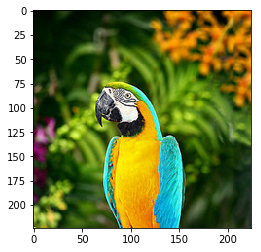

Predicted caption:
 a bird with a red beak perched on a branch eeee



In [73]:
generate_caption('./data/test/parrot_cropped1.jpg')

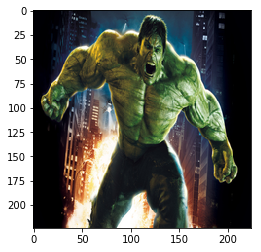

Predicted caption:
 a close up of a person holding a hot dog eeee



In [74]:
generate_caption('./data/test/hulk.jpg')

In [75]:
# image_model_transfer.save('image_model_transfer.h5')

In [76]:
# decoder_model.save('decoder_model.h5')

In [77]:
# from keras.models import model_from_json

In [78]:
# img_model_json = image_model_transfer.to_json()

# with open("model_img_jsn.json", "w") as json_file:
#     json_file.write(img_model_json)
    
# image_model_transfer.save_weights('model_img_jsn.h5')

In [79]:
# dec_json = decoder_model.to_json()

# with open("dec_jsn.json", "w") as json_file:
#     json_file.write(dec_json)
    
# image_model_transfer.save_weights('dec_jsn.h5')

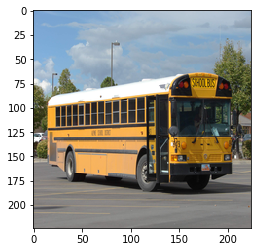

Predicted caption:
 a bus is parked on the side of the road eeee



In [80]:
generate_caption('./data/test/Alpine_School_District_school_bus.JPG')